In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alpyaman","key":"1c658a4c1d6f8b831b88a0f430209e6d"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# 📥 Download and extract the dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plant_data

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
replace plant_data/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [11]:
import os
base_dir = 'plant_data/PlantVillage'
print('Classes: ', len(os.listdir(base_dir)))
print('Example Class: ', os.listdir(base_dir)[0])
print('Image in one class: ', len(os.listdir(os.path.join(base_dir, os.listdir(base_dir)))))

Classes:  15
Example Class:  Potato___Early_blight


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'list'

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    'plant_data/PlantVillage',
    target_size=img_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset='training',
    shuffle=True
)

Found 16516 images belonging to 15 classes.


In [13]:
val_generator = datagen.flow_from_directory(
    'plant_data/PlantVillage',
    target_size=img_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=True
)

Found 4122 images belonging to 15 classes.


In [14]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),

    # Conv block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,575 (12.61 MB)

 Trainable params: 3,306,575 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 335s 644ms/step - accuracy: 0.3028 - loss: 2.1504 - val_accuracy: 0.6771 - val_loss: 0.9605
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 326s 630ms/step - accuracy: 0.6314 - loss: 1.1250 - val_accuracy: 0.7681 - val_loss: 0.7205
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 327s 632ms/step - accuracy: 0.6961 - loss: 0.8969 - val_accuracy: 0.8074 - val_loss: 0.5706
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 329s 636ms/step - accuracy: 0.7472 - loss: 0.7448 - val_accuracy: 0.8333 - val_loss: 0.4895
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 379s 630ms/step - accuracy: 0.7758 - loss: 0.6453 - val_accuracy: 0.8450 - val_loss: 0.4617
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 322s 623ms/step - accuracy: 0.7908 - loss: 0.6032 - val_accuracy: 0.8612 - val_loss: 0.4080
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 383s 625ms/step - accuracy: 0.8131 - loss: 0.5262 - val_accuracy: 0.8865 - val_loss: 0.3366
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 327s 632ms/step - accuracy: 0.8302 - loss: 0.48

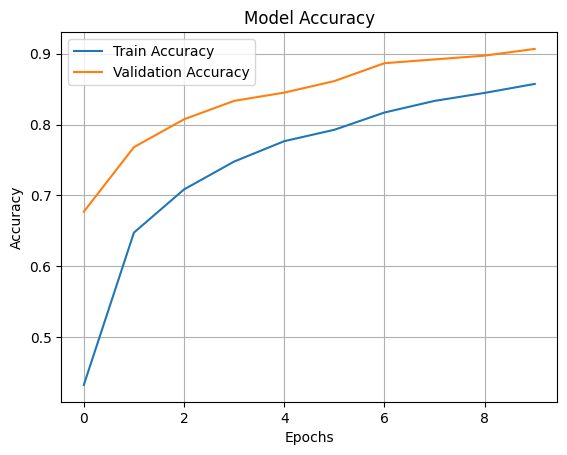

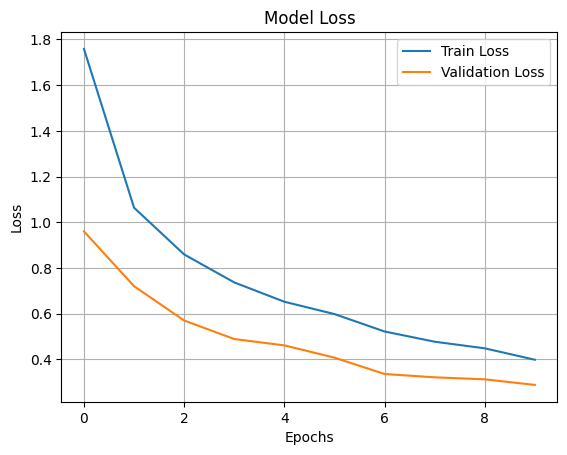

In [17]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

129/129 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.08      0.08      0.08       199
                     Pepper__bell___healthy       0.07      0.07      0.07       295
                      Potato___Early_blight       0.04      0.04      0.04       200
                       Potato___Late_blight       0.04      0.04      0.04       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.11      0.12      0.11       425
                        Tomato_Early_blight       0.05      0.03      0.04       200
                         Tomato_Late_blight       0.08      0.08      0.08       381
                           Tomato_Leaf_Mold       0.05      0.04      0.05       190
                  Tomato_Septoria_leaf_spot       0.09      0.11      0.10       354
Tomato_Spider_mites_

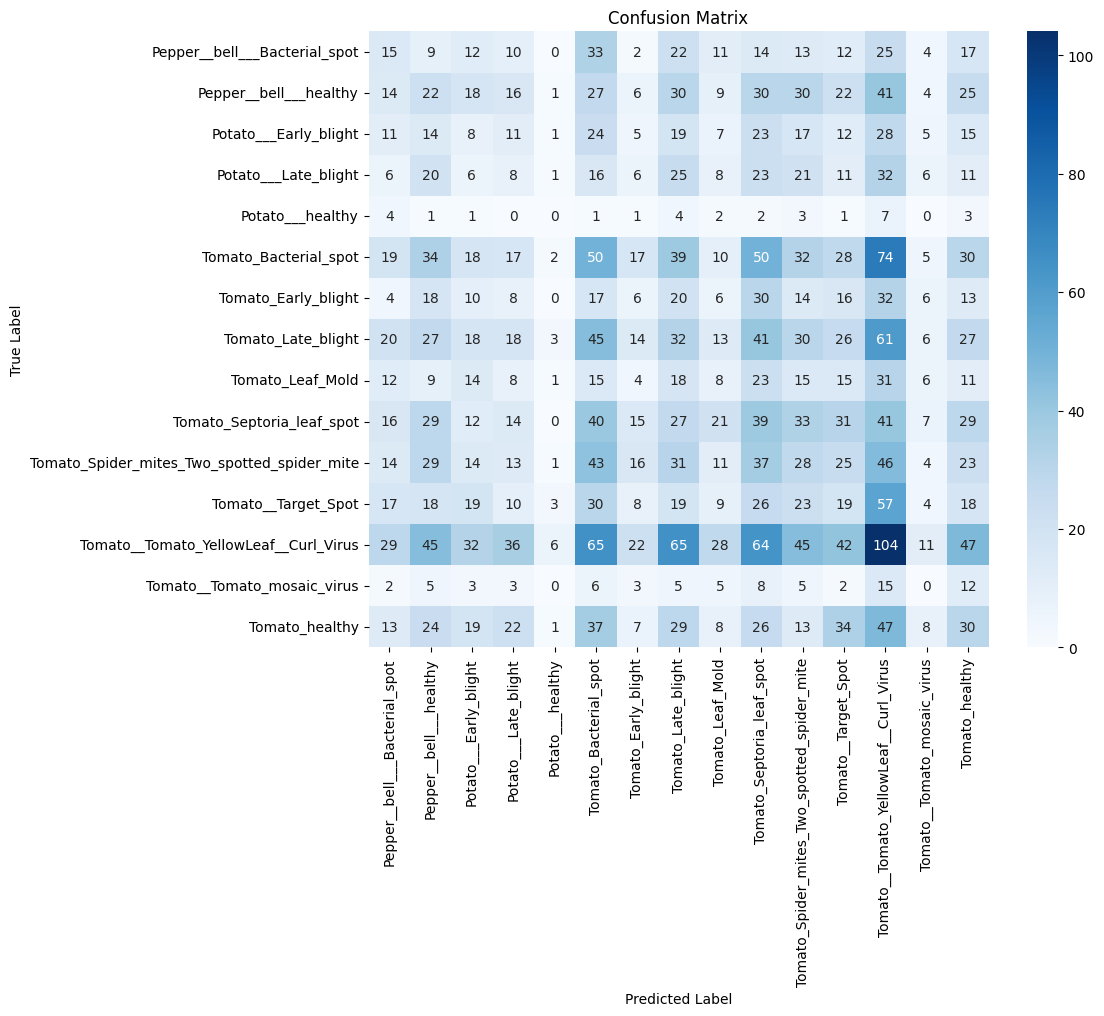

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predict on validation set
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Generate classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import json
with open('class_indices.json', 'w') as f:
    json.dump(val_generator.class_indices, f)
with open('history.json', 'w') as f:
    json.dump(history.history, f)

In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False # Freeze base layers

# Build the new top layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split = .2
)

train_generator = datagen.flow_from_directory(
    'plant_data/PlantVillage',
    target_size=img_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    'plant_data/PlantVillage',
    target_size=img_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [22]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 159s 299ms/step - accuracy: 0.6453 - loss: 1.1561 - val_accuracy: 0.8799 - val_loss: 0.3557
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 152s 293ms/step - accuracy: 0.8685 - loss: 0.4100 - val_accuracy: 0.9098 - val_loss: 0.2683
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 148s 287ms/step - accuracy: 0.8953 - loss: 0.3079 - val_accuracy: 0.9289 - val_loss: 0.2271
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 151s 293ms/step - accuracy: 0.9121 - loss: 0.2554 - val_accuracy: 0.9202 - val_loss: 0.2342
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 203s 295ms/step - accuracy: 0.9220 - loss: 0.2311 - val_accuracy: 0.9248 - val_loss: 0.2258
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 153s 297ms/step - accuracy: 0.9288 - loss: 0.2073 - val_accuracy: 0.9323 - val_loss: 0.2186
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 151s 291ms/step - accuracy: 0.9318 - loss: 0.1912 - val_accuracy: 0.9301 - val_loss: 0.2062
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 152s 293ms/step - accuracy: 0.9377 - loss: 0.17

In [23]:
# 🔓 Unfreeze the last few layers
base_model.trainable = True

# Recompile with lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune (use fewer epochs)
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.5499 - loss: 3.3126 - val_accuracy: 0.8882 - val_loss: 0.4725
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 514s 995ms/step - accuracy: 0.8214 - loss: 0.7531 - val_accuracy: 0.9003 - val_loss: 0.4206
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.8731 - loss: 0.4869 - val_accuracy: 0.9090 - val_loss: 0.3470
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 517s 999ms/step - accuracy: 0.9046 - loss: 0.3366 - val_accuracy: 0.9265 - val_loss: 0.2741
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 510s 987ms/step - accuracy: 0.9190 - loss: 0.2808 - val_accuracy: 0.9352 - val_loss: 0.2281


129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 276ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.93      0.96       199
                     Pepper__bell___healthy       0.95      0.99      0.97       295
                      Potato___Early_blight       0.98      0.99      0.99       200
                       Potato___Late_blight       0.97      0.90      0.93       200
                           Potato___healthy       0.81      0.97      0.88        30
                      Tomato_Bacterial_spot       0.98      0.93      0.95       425
                        Tomato_Early_blight       0.89      0.73      0.80       200
                         Tomato_Late_blight       0.89      0.96      0.92       381
                           Tomato_Leaf_Mold       0.89      0.96      0.92       190
                  Tomato_Septoria_leaf_spot       0.93      0.90      0.91       354
Tomato_Spider_mites_

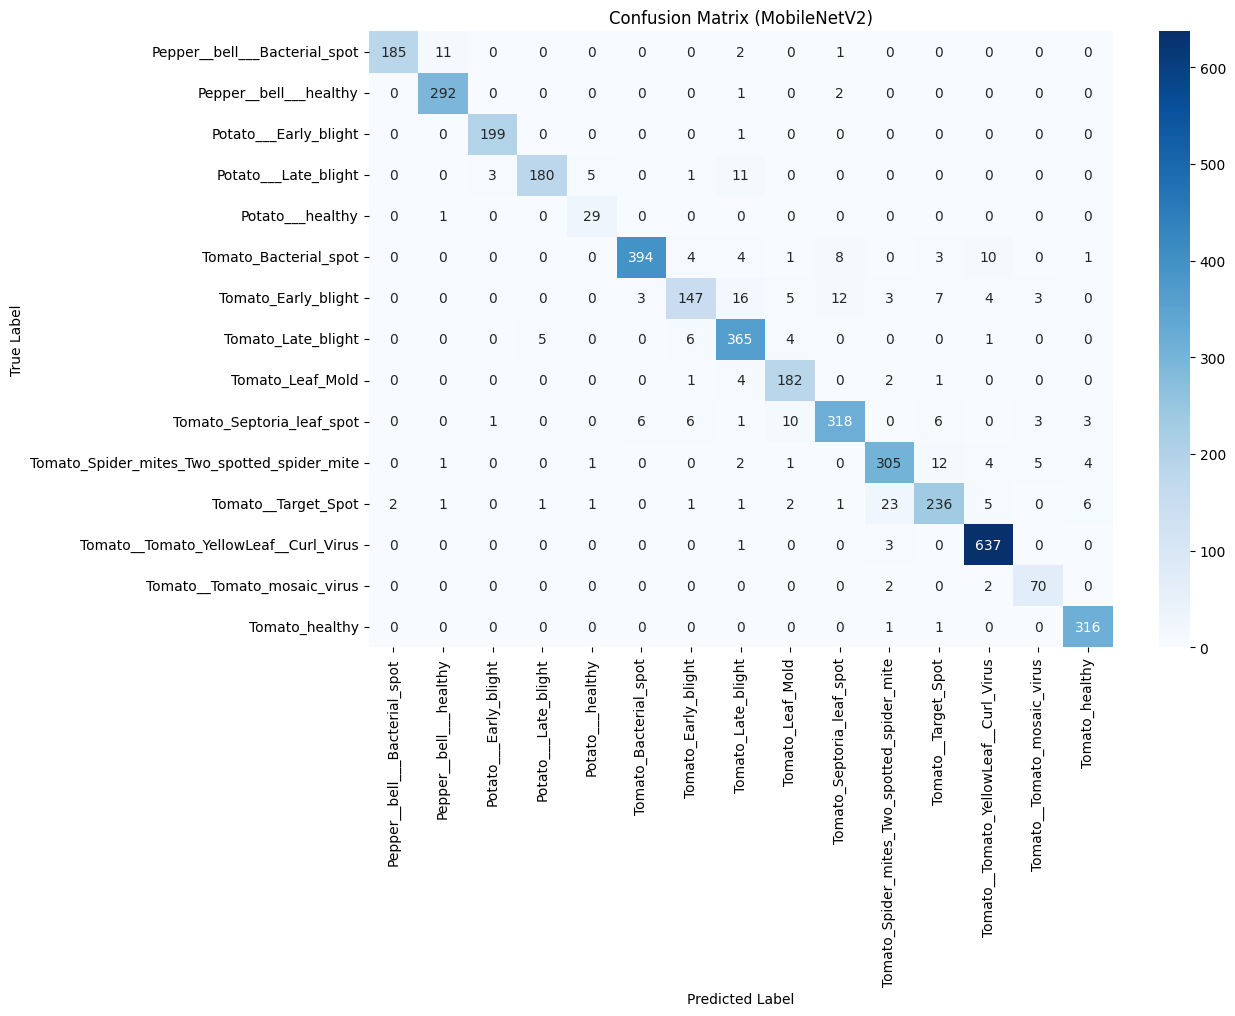

In [24]:
# Predict on validation set
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Generate classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (MobileNetV2)')
plt.show()